

>
## Mount drive



In [ ]:
from google.colab import drive
import sys
import py
import pickle
import warnings
import os
from IPython.display import clear_output

import itertools
import multiprocessing
# drive.mount('/content/drive')
# %cd drive
# %cd My\ Drive
# %cd IR1
# %cd assignment\ 2
# !ls

# !ls
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Big data')
cwd = os.getcwd()
cwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/content/drive/My Drive/Big data'

# DEPENDENCIES

In [ ]:
import re,string,random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

!pip3 install nltk==3.4.5
!pip install --upgrade gensim
!pip3 install pyLDAvis
!apt install enchant  # you need this for pyenchant
!pip3 install pyenchant
!pip3 install textblob
import textblob
# add some words to textblob to ignore ; 
list_exclude = ['sensor','amzn','edrive','etruck', 'suvs', 'elon','musk' , 'ppl', 'incl' , 'excl', 'lol' , 'wtf' ,
                             'lmao', 'rofl', 'div','tlsa' , 'dino' ,'tesla' ,'wuhan' , 'corona' , 'covid','trump','donald', 'ooo','benzinga','bazinga','jb','straubel','nikolai','nokia','deathtrap']

dict_word = { key : 1 for key in list_exclude }
textblob.en.spelling.update(dict_word)

from textblob import TextBlob,Word
import enchant # vocabulary to process words stuck together

import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.tokenize import TweetTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
#from nltk.stem import WordNetLemmatizer

import gensim
from gensim import models, corpora
from gensim.corpora import Dictionary
from gensim.test.utils import common_dictionary, common_corpus
from gensim import similarities
from gensim.models.ldamodel import LdaModel

from gensim.models.hdpmodel import HdpModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import scipy
import spacy # lemmatization

# Already given dependencies by faculty


# Interactive plots for LDA
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt


import json
from collections import deque,defaultdict,Counter, OrderedDict
# from tqdm import tqdm
# from datetime import datetime
# from datetime import timedelta

#clear output
%matplotlib inline
clear_output()

In [ ]:
# check versions 
print('NLTK: ' + nltk.__version__)
print('Gensim: ' + gensim.__version__)
print('pyLDAvis: ' + pyLDAvis.__version__)
print('Enchant: ' + enchant.__version__)

NLTK: 3.4.5
Gensim: 3.8.1
pyLDAvis: 2.1.2
Enchant: 3.0.1


# Creating the data structures for topic analysis

In [ ]:
# You need these functions for th:  get_topic_data ()
def read_events():
    with open("events.json", "r") as read_file:
        return json.load(read_file)
events = read_events()

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def remove_ends(text):
  for j,i in enumerate(reversed(text)):
    if i.startswith('#') or i.startswith('$') or i.startswith('&') or i in list(string.punctuation) or i in stop_words:
      continue
    elif j == 0:
      text =text
    else:
      text = text[:-j]
      break
  return text

# define stop_words:
stop_words = stopwords.words('english')
stop_words.remove("down")
stop_words.remove("up")
stop_words.remove("against")
stop_words.extend(['from', 'subject', 're', 'edu', 'use','via',
"tsla","tesla","nos"])  # add Tesla because it doesnt add any value to the topic analysis.


def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in text:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

### Pre-process text : NLTK

In [ ]:
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

# make a function to process words stuck together
list_exclude = ['sensor','amzn','edrive','etruck', 'suvs', 'elon','musk' , 'ppl', 'incl' , 'excl', 'lol','lolza', 'wtf' ,
                             'lmao', 'rofl', 'div','tlsa' , 'dino' ,'tesla' ,'wuhan' , 'corona' , 'covid','trump','donald', 'ooo','jb','straubel','nikolai','nokia','usn','youtuber','deathtrap']

eng_dict = enchant.Dict("en_US")
for i in list_exclude:
  eng_dict.add(i)
eng_dict.add("electriic")
#eng_dict.add("innoson")




def segment_string(chars, exclude=None):
    """
    Segment a string of chars using the pyenchant vocabulary.
    Keeps longest possible words that account for all characters,
    and returns list of segmented words.

    :param chars: (str) The character string to segment.
    :param exclude: (set) A set of string to exclude from consideration.
          
                    If an excluded word occurs later in the string, this
                    function will fail.
    """
    words = []

    if not chars.isalpha():  # don't check punctuation etc.; needs more work
        return [chars]

    if not exclude:
        exclude = set()

    working_chars = chars
    while working_chars:
        # iterate through segments of the chars starting with the longest segment possible
        for i in range(len(working_chars), 1, -1):
            segment = working_chars[:i]
            if eng_dict.check(segment) and segment not in exclude:
                words.append(segment)
                working_chars = working_chars[i:]
                break
        else:  # no matching segments were found
            if words:
                exclude.add(words[-1])
                return segment_string(chars, exclude=exclude)
            # let the user know a word was missing from the dictionary,
            # but keep the word
            return [chars]
    # return a list of words based on the segmentation
    return words    



    # split data in chunks : 
    def chunkify(lst,n):
      return [lst[i::n] for i in range(n)]

## MapReduce

In [ ]:
class SimpleMapReduce(object):
    
    def __init__(self, map_func, reduce_func, num_workers=None):
        """
        map_func

          Function to map inputs to intermediate data. Takes as
          argument one input value and returns a tuple with the key
          and a value to be reduced.
        
        reduce_func

          Function to reduce partitioned version of intermediate data
          to final output. Takes as argument a key as produced by
          map_func and a sequence of the values associated with that
          key.
         
        num_workers

          The number of workers to create in the pool. Defaults to the
          number of CPUs available on the current host.
        """
        self.map_func = map_func
        self.reduce_func = reduce_func
        self.pool = multiprocessing.Pool(num_workers)
    
    def partition(self, mapped_values):
        """Organize the mapped values by their key.
        Returns an unsorted sequence of tuples with a key and a sequence of values.
        """
        partitioned_data = collections.defaultdict(list)
        for key, value in mapped_values:
            partitioned_data[key].append(value)
        return partitioned_data.items()
    
    def __call__(self, inputs, chunksize=1):
        """Process the inputs through the map and reduce functions given.
        
        inputs
          An iterable containing the input data to be processed.
        
        chunksize=1
          The portion of the input data to hand to each worker.  This
          can be used to tune performance during the mapping phase.
        """
        map_responses = self.pool.map(self.map_func, inputs, chunksize=chunksize)
        partitioned_data = self.partition(itertools.chain(*map_responses))
        reduced_values = self.pool.map(self.reduce_func, partitioned_data)
        return reduced_values

In [ ]:
def file_to_words(filename):
    """Read a file and return a sequence of (word, occurances) values.
    """
    STOP_WORDS = set([
            'a', 'an', 'and', 'are', 'as', 'be', 'by', 'for', 'if', 'in', 
            'is', 'it', 'of', 'or', 'py', 'rst', 'that', 'the', 'to', 'with',
            ])
    TR = string.maketrans(string.punctuation, ' ' * len(string.punctuation))

    print (multiprocessing.current_process().name, 'reading', filename)
    output = []

    with open(filename, 'rt') as f:
        for line in f:
            if line.lstrip().startswith('..'): # Skip rst comment lines
                continue
            line = line.translate(TR) # Strip punctuation
            for word in line.split():
                word = word.lower()
                if word.isalpha() and word not in STOP_WORDS:
                    output.append( (word, 1) )
    return output


def count_words(item):
    """Convert the partitioned data for a word to a
    tuple containing the word and the number of occurances.
    """
    word, occurances = item
    return (word, sum(occurances))


if __name__ == '__main__':
    import operator
    import glob

    input_files = glob.glob('*.rst')
    
    mapper = SimpleMapReduce(file_to_words, count_words)
    word_counts = mapper(input_files)
    word_counts.sort(key=operator.itemgetter(1))
    word_counts.reverse()
    
    print ('\nTOP 20 WORDS BY FREQUENCY\n')
    top20 = word_counts[:20]
    longest = max(len(word) for word, count in top20)
    for word, count in top20:
        print ('%-*s: %5s' % (longest+1, word, count))

## Processing Data

In [ ]:
warnings.filterwarnings("ignore")
# Write a function to process tweets: 
def get_dict_data(events = events): 

  dict_df = {} # a dict to store all the text-tweets across multiple keys(event dates)
  for event in events["events"]:
      filename = event["start_date"] + "_" + event["end_date"]
      start_date = event["start_date"]
      # start_date = datetime.strptime(event["start_date"], '%Y-%m-%d').date()
      with open("tweets/results/" + filename + ".json", "r") as twitter_file:
        twitter_data = json.load(twitter_file)["tweets"]
        dict_df.update( {start_date:[sub['text'] for sub in twitter_data]} )


  for key in dict_df.keys():
    dict_df.update({key: [re.sub('\S*@\S*\s?', '', sent) for sent in dict_df[key]]})
    dict_df.update({key: [re.sub('\s+', ' ', sent) for sent in dict_df[key]]}) 
    dict_df.update({key: [re.sub(r"http\S+", "", sent)   for sent in dict_df[key]]}) 
    dict_df.update({key: [TweetTokenizer().tokenize(sent) for sent in dict_df[key]]})
    dict_df.update({key: [remove_ends(sent) for sent in dict_df[key]]})
    dict_df.update({key: [remove_ends(sent) for sent in dict_df[key]]}) # twice, because of cases such as dict_df['2019-07-24'][3]
    dict_df.update({key: [[TreebankWordDetokenizer().detokenize(sent)] for sent in dict_df[key]]})
    dict_df.update({key: [[word for word in simple_preprocess(str(sent),deacc= True) if word not in stop_words] for sent in dict_df[key]]})  #remove_stopwords and get back tokenized datar

# [list(itertools.chain.from_iterable([list(*[segment_string(word)]) for word in sent  if word not in stop_words])) for sent in dict_df['2019-07-24']]  

## list(itertools.chain.from_iterable([list(*[segment_string(word)]) for sent in dict_df['2019-07-24'] for word in sent if word not in stop_words]))
   

   ## Lemmatization:  + taking care of words stuck together
  return dict_df
def get_topic_data(spelling = False):

  dict_df = get_dict_data()    
  for key in dict_df.keys():
    dict_df[key] = [list(itertools.chain.from_iterable([list(*[segment_string(word)]) 
                    for word in sent  if word not in stop_words])) for sent in dict_df[key]]   
    dict_df[key] = lemmatization(dict_df[key],allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # takes some time

    if spelling == True: 
        dict_df.update({key: [[str(TextBlob(word).correct()) for word in sent] for sent in dict_df[key]]})

  if spelling == True: 
    save_obj(dict_df,"dict_df_TextBlob")
  else: 
     save_obj(dict_df,"dict_df")
  return dict_df
  #  # dict_df.update({key: lemmatization(dict_df[key],allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])}) # takes some time
# make sure to put in the report the limitation of the app for 3 days. 
# Meaning it assumes that dates/days dont overlap between events, because of avoiding of duplicates

### LOAD/MAKE data dictionary here

You can choose between two options : **With** spelling check implemented and **without**

In [ ]:
# options = ('with', 'without')
# result = input() #str()

start_time = time.time()
if os.path.exists("dict_df_TextBlob.pkl"):
  dict_df = load_obj("dict_df_TextBlob")
else:
  dict_df = get_topic_data(spelling = True)


# else: 
#   if os.path.exists("dict_df.pkl"):
#     dict_df = load_obj("dict_df")
#   else:
#     dict_df = get_topic_data(spelling = False)
  
print(dict_df['2019-07-24'][2])
print(dict_df.keys())
doc_names = list(dict_df.keys())
print("--- %s minutes ---" % ((time.time() - start_time)/60))

['ran', 'video', 'wiki', 'wiki', 'wrap', 'god', 'kid', 'amateur', 'wrapped', 'dog', 'white', 'wrapped', 'slim', 'charge', 'real', 'tube']
dict_keys(['2019-11-21', '2020-02-04', '2019-07-24'])
--- 0.00040749311447143557 minutes ---


# Outer or Inner analysis of the # events  and LDA

In [ ]:
# Initiate LDA mallet path:

# os.environ['MALLET_HOME'] = '/mallet-2.0.8'
# mallet_path = '/mallet-2.0.8/bin/mallet.bat' 


# CHOOSE OPTIMAL LDA: 
def compute_coherence_values(dictionary , corpus, texts, limit=31, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def get_doc_topic(corpus, model):
  doc_topic = np.array([[y for (x,y) in model[corpus[i]]] for i in range(len(corpus))])
  return doc_topic


def topic_prob_extractor(gensim_hdp, t=9000, w=25, isSorted=True):
    """
    Input the gensim model to get the rough topics' probabilities
    """
    shown_topics = gensim_hdp.show_topics(num_topics=t, num_words=w ,formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]
    if (isSorted):
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights}).sort_values(by = "weight", ascending=False).reset_index(drop = True)
    else:
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights}).reset_index(drop = True)


### MULTICORE LDA vs Normal LDA

In [ ]:
# check number of cores colab
from psutil import *
cpu_count()

4

In [ ]:
# results = get_model_out(dict_df = dict_df, num_topics = None,     # change num_topics to some value (11) for a fast run, else None
#                         limit=33,  start=8, step=3, num_words = 8, 
#                         show_graph = True,show_num_topics = -1, random_state = 100,multi = False)

In [ ]:
def model_config(corpus,dictionary,num_topics = 10, random_state = 100, multi = False):
  if multi == True:
    lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                  id2word=dictionary,
                                                  num_topics= num_topics,
                                                  workers= 3, 
                                                  chunksize=100,
                                                  passes=10, 
                                                  alpha='symmetric',    # auto is not implemented yet
                                                  random_state=random_state,
                                                  per_word_topics=True,
                                                  minimum_probability= 0.1)
  else:
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics= num_topics, 
                                            random_state=random_state,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True,
                                            minimum_probability= 0.1)
  
  return lda 

In [ ]:
def get_model_out(dict_df = dict_df, num_topics = None,limit=31,  start=2, step=3, num_words = 8, show_graph = False,show_num_topics = -1, random_state = 100, multi = False):
  start_time = time.time()
  #num_words = 6
   
  # OUTPUT : 
  results = {}
  

  for key in dict_df.keys():
    print("Event taken into consideration: {}".format(str(key)))
    #intermediary:
    c_v = []   # saves coherence scores
    model_list = [] # saves models
    topic_weights = []  # for extracting dominant topic
    tokenized_corpus = dict_df[key]
    id2word = corpora.Dictionary(tokenized_corpus)
    corpus = [id2word.doc2bow(text) for text in tokenized_corpus]
    #run model
    if num_topics == None:
      for topic in range(start, limit, step):
          model = model_config(corpus = corpus,dictionary = id2word,num_topics = topic, random_state = random_state,multi = multi)
          model_list.append(model)
          cm = CoherenceModel(model=model, texts=tokenized_corpus, dictionary=id2word, coherence='c_v')
          c_v.append(cm.get_coherence())
      # optimal take max c_v:
      model = model_list[c_v.index(max(c_v))]
      if show_graph == True: 
        x = range(start, limit,step)
        plt.plot(x, c_v)
        plt.xlabel("num_topics")
        plt.ylabel("Coherence score")
        plt.legend(("c_v"), loc='best')
        plt.show()
    else: 
      model = model_config(corpus = corpus,dictionary = id2word,num_topics = num_topics, random_state = random_state,multi = multi)
      model_list.append(model)
      cm = CoherenceModel(model=model, texts=tokenized_corpus, dictionary=id2word, coherence='c_v')
      c_v.append(cm.get_coherence())
      

    model = model_list[c_v.index(max(c_v))]
    model_topics = model.show_topics(num_words=num_words,formatted = False, num_topics = show_num_topics)
    topics = {}
    for j in [i[0] for i in model_topics] :
      topics[j] = dict(model_topics[j][1])

    # OUTPUT 
    results[key] = {'Model': {"score": max(c_v),"all_scores": c_v, "num_topics":len(topics),"topics":topics,"model" : model},
                    "data" : {"corpus" : corpus, "dictionary" : id2word, "tokenized_corpus" : tokenized_corpus}}

  print("\n --- %s minutes ---" % round(((time.time() - start_time)/60),4))
  return results

  # Inspect Corpus: 
  #[[(id2word[id], freq) for id, freq in N] for N in corpus[:1]][:4]

Event taken into consideration: 2019-11-21


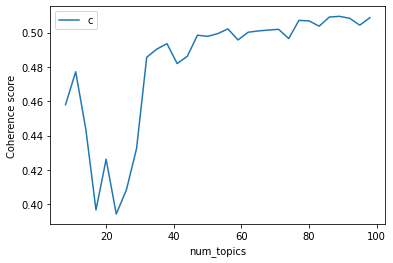

Event taken into consideration: 2020-02-04


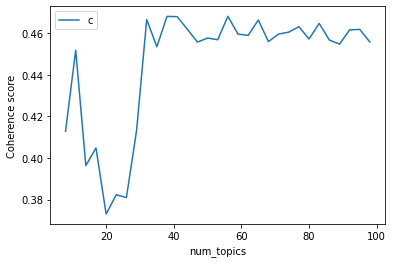

Event taken into consideration: 2019-07-24


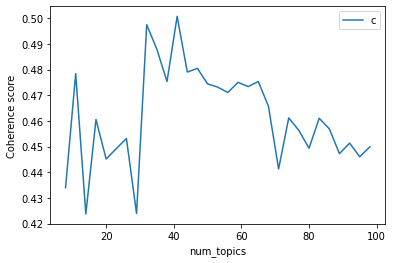


 --- 30.6089 minutes ---


In [ ]:
results = get_model_out(dict_df = dict_df, num_topics = None,     # change num_topics to some value (32) for a fast run, else None
                        limit=100,  start=8, step=3, num_words = 8, 
                        show_graph = True,show_num_topics = -1, random_state = 100,multi = False)

In [ ]:
print(results.keys())
print([results[i]["Model"]['score'] for i in results.keys()])
print([results[i]["Model"]['num_topics'] for i in results.keys()])

dict_keys(['2019-11-21', '2020-02-04', '2019-07-24'])
[0.5095225585641597, 0.46809076623015755, 0.5008124836214254]
[89, 56, 41]


Event taken into consideration: 2019-11-21


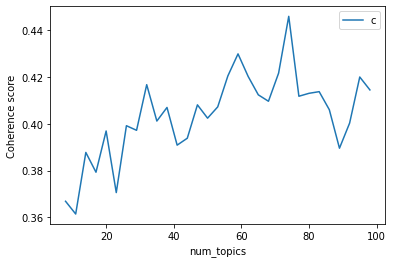

Event taken into consideration: 2020-02-04


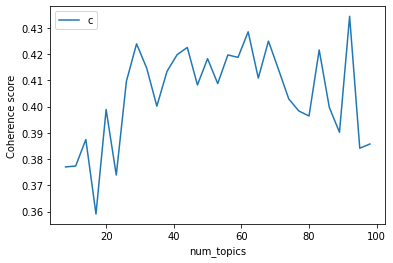

Event taken into consideration: 2019-07-24


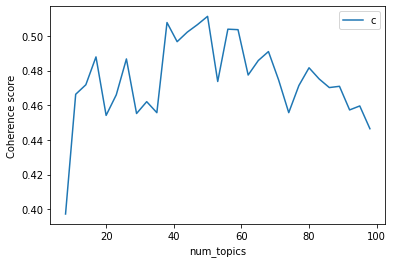


 --- 16.6786 minutes ---


In [ ]:
results = get_model_out(dict_df = dict_df, num_topics = None,     # change num_topics to some value (32) for a fast run, else None
                        limit=100,  start=8, step=3, num_words = 8, 
                        show_graph = True,show_num_topics = -1, random_state = 100,multi = True)

In [ ]:
print(results.keys())
print([results[i]["Model"]['score'] for i in results.keys()])
print([results[i]["Model"]['num_topics'] for i in results.keys()])

dict_keys(['2019-11-21', '2020-02-04', '2019-07-24'])
[0.44597671082261325, 0.4344008973941644, 0.5114145272869339]
[74, 92, 50]


In [ ]:
results = get_model_out(dict_df = dict_df, num_topics = 32,     # change num_topics to some value (32) for a fast run, else None
                        limit=35,  start=8, step=3, num_words = 8, 
                        show_graph = True,show_num_topics = -1, random_state = 100,multi = False)

Event taken into consideration: 2019-11-21
Event taken into consideration: 2020-02-04
Event taken into consideration: 2019-07-24

 --- 0.7167 minutes ---


In [ ]:
print(results.keys())
print([results[i]["Model"]['score'] for i in results.keys()])
print([results[i]["Model"]['num_topics'] for i in results.keys()])

dict_keys(['2019-11-21', '2020-02-04', '2019-07-24'])
[0.4856351882565083, 0.46654466908612463, 0.49755658605778413]
[32, 32, 32]


Event taken into consideration: 2019-11-21


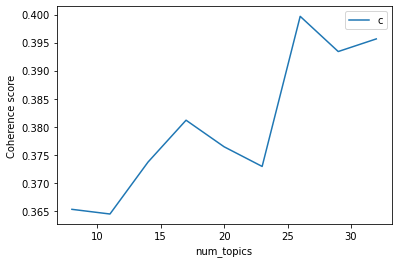

Event taken into consideration: 2020-02-04


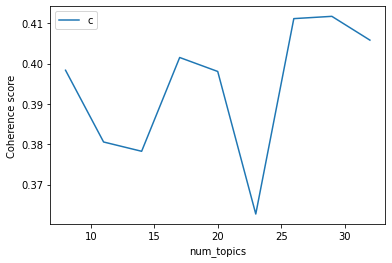

Event taken into consideration: 2019-07-24


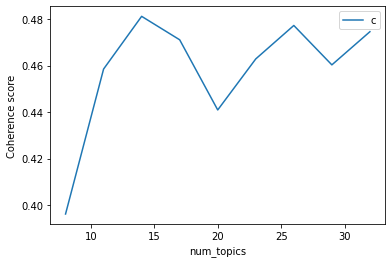


 --- 2.7951 minutes ---


In [ ]:
results = get_model_out(dict_df = dict_df, num_topics = None,     # change num_topics to some value (32) for a fast run, else None
                        limit=35,  start=8, step=3, num_words = 8, 
                        show_graph = True,show_num_topics = -1, random_state = 100,multi = True)

In [ ]:
print(results.keys())
print([results[i]["Model"]['score'] for i in results.keys()])
print([results[i]["Model"]['num_topics'] for i in results.keys()])

dict_keys(['2019-11-21', '2020-02-04', '2019-07-24'])
[0.39969311977246724, 0.41173809714854054, 0.48111973164359106]
[26, 29, 14]


In [ ]:
corpus = results[list(results.keys())[2]]["data"]["corpus"]
id2word = results[list(results.keys())[2]]["data"]["dictionary"]

In [ ]:
panel = pyLDAvis.gensim.prepare(results[list(results.keys())[2]]["Model"]["model"],  corpus, id2word, mds='tsne') #
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
14    -107.920052  110.578323       1        1  8.031726
21    -139.934921   53.383816       2        1  7.435653
17      46.482380 -152.155334       3        1  6.568848
9      -18.605953  -36.275871       4        1  6.417190
1       56.181190  -95.210449       5        1  5.009778
16     -11.599965 -127.978027       6        1  4.569930
20      18.074890  148.156158       7        1  4.265867
31      86.356453  -50.095238       8        1  4.257104
26      49.537304   94.440277       9        1  4.127279
3      -44.447296  136.309174      10        1  3.898349
5      -76.162674 -129.069962      11        1  3.872791
7     -128.143188  -13.070354      12        1  3.601101
28     147.179398  -33.938496      13        1  3.323859
18     -42.291656    8.253832      14        1  3.151593
15     -58.647541   76.117180      15        1  3.112503
19      95.664894   -1.334991      16        1  3.103542
30     117.328171 -101.417633      17        1  2.466862
27       7.086892  -76.606575      18        1  2.202306
12      86.025604  136.739441      19        1  2.169815
6     -107.474266  -70.047882      20        1  2.035496
24      76.723946   47.345974      21        1  1.948788
11     -48.011772  -76.365837      22        1  1.927495
10     139.828049   30.255438      23        1  1.920089
25     -19.571854   46.331726      24        1  1.779842
29     116.378410   83.290840      25        1  1.703086
22      -3.992424   92.362686      26        1  1.547020
4       35.967690  -38.353668      27        1  1.335426
2       26.359602   47.443275      28        1  1.329017
13     -85.248611   30.322466      29        1  1.212775
0      -70.299850  -27.312397      30        1  0.962934
8       47.957268    5.662566      31        1  0.624249
23       4.730116    3.455688      32        1  0.087694, topic_info=        Term        Freq       Total Category  logprob  loglift
9      model  987.000000  987.000000  Default  30.0000  30.0000
301      car  992.000000  992.000000  Default  29.0000  29.0000
147     elon  698.000000  698.000000  Default  28.0000  28.0000
31       get  384.000000  384.000000  Default  27.0000  27.0000
385     musk  541.000000  541.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
1167     org    0.008558    1.575835  Topic32  -8.1755   1.8234
1191    pack    0.008558    1.575835  Topic32  -8.1755   1.8234
1193    taxi    0.008558    1.575835  Topic32  -8.1755   1.8234
1165    holy    0.008558    1.575835  Topic32  -8.1755   1.8234
1207  strike    0.008558    1.575835  Topic32  -8.1755   1.8234

[1529 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
501      11  0.986957      able
299       3  0.987707    accord
432       5  0.872631  actually
334       9  0.383767   adapted
313      20  0.808136  advisory
...     ...       ...       ...
214       1  0.191340      year
214       6  0.696819      year
214      17  0.108521      year
172      15  0.788755       yes
190       2  0.974962       you

[443 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 22, 18, 10, 2, 17, 21, 32, 27, 4, 6, 8, 29, 19, 16, 20, 31, 28, 13, 7, 25, 12, 11, 26, 30, 23, 5, 3, 14, 1, 9, 24])

# Topic analysis code

## LDA

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= 23, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
coherence_model = CoherenceModel(model=lda_model, texts=tokenized_corpus, dictionary=id2word, coherence='c_v')
lda_coherence = coherence_model.get_coherence()
print('Number of documents/tweets considered: ', len(tokenized_corpus))
print('\nCoherence Score: ', lda_coherence)

Number of documents/tweets considered:  3113

Coherence Score:  0.44919911963213116


## Experiment

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from gensim import corpora
import gensim

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()


def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    return punc_free


doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."
doc4 = "Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better."
doc5 = "Health experts say that Sugar is not good for your lifestyle."

# Integrate document data
doc_complete = [doc1, doc2, doc3, doc4, doc5]


doc_clean = [clean(doc).split() for doc in doc_complete]

# Create a lexical dictionary of words, each individual word will be given an index
dictionary = corpora.Dictionary(doc_clean)

# Using the above dictionary, change the converted document list (corpus) into a DT matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

len(doc_term_matrix)


5

In [ ]:
corpus = results[list(results.keys())[2]]["info"]["corpus"]
id2word = results[list(results.keys())[2]]["info"]["id2word"]
tokenized_corpus = results[list(results.keys())[2]]["info"]["tokenized_corpus"]

len(corpus)

3113

## HDP

In [ ]:
hdp = HdpModel(corpus=corpus,id2word=id2word,random_state = 100,
                                           chunksize=100,
                                           T = 100)
hdp_cm=CoherenceModel(model=hdp,corpus= corpus,texts=tokenized_corpus, dictionary= id2word,coherence='c_v')
HDP_coherence=hdp_cm.get_coherence()
print('\nCoherence Score: ', HDP_coherence)


Coherence Score:  0.7404322259454884


In [ ]:
hdp_topics = hdp.print_topics()
print(len(hdp_topics))
for topic in hdp_topics:
  print(topic)

20
(0, '0.017*ev + 0.016*sale + 0.007*battery + 0.006*global + 0.006*hour + 0.006*terawatt + 0.006*exponentially + 0.006*usual + 0.006*forecast + 0.006*enough')
(1, '0.003*degenerative + 0.002*competitive + 0.002*capital + 0.002*yes + 0.002*prefer + 0.002*ch + 0.002*brignole + 0.002*risk + 0.002*division + 0.002*increase')
(2, '0.004*car + 0.004*order + 0.004*true + 0.003*meet + 0.003*save + 0.003*prepare + 0.003*enjoyable + 0.002*go + 0.002*smile + 0.002*private')
(3, '0.003*ribs + 0.002*merge + 0.002*charm + 0.002*custodian + 0.002*technically + 0.002*strike + 0.002*insider + 0.002*readable + 0.002*nickel + 0.002*idiot')
(4, '0.004*car + 0.003*order + 0.003*many + 0.002*big + 0.002*manipulation + 0.002*arcade + 0.002*cool + 0.002*subsidies + 0.002*level + 0.002*lot')
(5, '0.003*phantom + 0.003*musk + 0.002*jaffa + 0.002*learning + 0.002*loafer + 0.002*grocer + 0.002*century + 0.002*wire + 0.002*speculator + 0.002*decentralize')
(6, '0.002*adapted + 0.002*see + 0.002*share + 0.002*reg

In [ ]:
tokenized_corpus[1111]

['stock', 'triple', 'price', 'fund', 'manager', 'barron', 'price', 'target']

## PyLDAvis

In [ ]:
# panel = pyLDAvis.gensim.prepare(hdp,  corpus, id2word, mds='tsne') #
# panel
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    id2word : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v


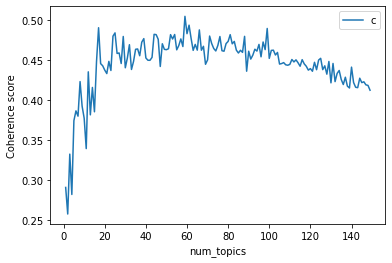

In [ ]:
lmlist, c_v = evaluate_graph(dictionary=id2word, corpus=corpus, texts=tokenized_corpus, limit=150)

In [ ]:
#16 c_v.index(max(c_v))
cm = CoherenceModel(model=lmlist[16], texts=tokenized_corpus, dictionary=id2word, coherence='c_v')
cm.get_coherence()
lda_model = lmlist[16]

In [ ]:
panel = pyLDAvis.gensim.prepare(hdp,corpus, id2word, mds='tsne') #


**TESTING** TEXTBLOB: 
- As we can see here, it is much better to just not do any general spelling modifications, since in the majority of the cases the meaning gets lost or totally misinterpreted.

In [ ]:
l = ["participatedeathtrap","usn","donaldtrump","elonmusk","cybertruck","lolza",
     "teslafilm","mythlive","innoson","iwm","itscoldoutside","suvs",
     "zuckerbrat","amzn","hackett","galaxys","bigdata","gloviscosmo","ooo","oopp","sliight","dino","ipobubble","edrive","wtf"]
k = list(itertools.chain(*list([segment_string(word) for word in l])))
k

['participated',
 'eat',
 'ht',
 'rap',
 'usn',
 'donald',
 'trump',
 'elon',
 'musk',
 'cybertruck',
 'lolza',
 'tesla',
 'film',
 'myth',
 'live',
 'innoson',
 'iwm',
 'its',
 'cold',
 'outside',
 'suvs',
 'zuckerbrat',
 'amzn',
 'hackett',
 'galaxys',
 'bigdata',
 'gloviscosmo',
 'ooo',
 'oopp',
 'sliight',
 'dino',
 'ipobubble',
 'edrive',
 'wtf']

In [ ]:
# List of words to be added as exceptions for Textblob and segment_string

[str(TextBlob(word).correct())
  for word in k]

In [ ]:
Word('pus').spellcheck()


[('richmond', 1.0)]

In [ ]:
# df = pd.DataFrame.from_dict(data = twitter_data)
# df = df[selection_keys]
# # df['created_at']= pd.to_datetime(df['created_at']) 
# start_date.strftime("%Y-%m-%d")



```
# This is formatted as code
```

## OLD **CODE**

In [ ]:

      #   hdp_topics = hdp.print_topics()
      #   topics = []
      #   for topic in hdp_topics:
      #     topics.append(topic)
      #   results[key] = {typ: {"score":HDP_coherence, "num_topics":len(hdp_topics),"topics":topics}}
      # print(results)

In [ ]:
def print10mostrelevantdocumentsLSI(query, lsi_model, train_corpus):
    """Takes in a preprocessed query/doc, and prints the 10 most similar documents from the corpus"""
    
    vec_bow = dictionary.doc2bow(testdocuments[docID])
    vec_lsi = lsi_model[vec_bow]  # convert the query to LSI space
    index = similarities.MatrixSimilarity(lsi_model[corpus])
   
    sims = index[vec_lsi]  # perform a similarity query against the corpus
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
   
    for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('THIRD', 2), ('4th', 3), 
                         ('5th', 4), ('6th', 5), ('7th', 6), ('8th', 7), ('9th', 8), ('10th', 9) ]:

       print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))
       
       
    return null 

def getrankLSIforquery(query, lsi_model, index):
    """ Takes in a query, and given a model and modelindex, return a list of (doc_id, cosine similarity score) """
    
    query_repr = read_ap.process_text(query)
    vec_bow = dictionary.doc2bow(query_repr)
    vec_lsi = lsi_model[vec_bow]
    
    sims = index[vec_lsi]   
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    rank = [(index2docID[i], float(j)) for i, j in sims]
    
    return rank
## Show TOPICS, and what topics are made of

def ShowTopics(model, num_topics, num_words):
    """Given a model, returns a number of topics. And what these topics are made of """

    listoftopics = model.show_topics(num_topics = num_topics, num_words = num_words)
    for topic_id, topic in listoftopics:
        print(topic_id, topic)
        print("\n")


def getMetrics(validation_test_queries, validation_test_qrel, lsi_model):
    """ validation_test_queries: can either be queries, validationqueries, or testqueries"""

    overall_ser = {}
    index = similarities.MatrixSimilarity(lsi_model[corpus])
    print("Running DOC2VEC")
      # VALIDATION
    for qid in validation_test_qrel: 
        query_text = queries[qid]
        results = getrankLSIforquery(query_text, lsi_model, index)
        overall_ser[qid] = dict(results)
      
    evaluator = pytrec_eval.RelevanceEvaluator(validation_test_qrel, {'map', 'ndcg'})
    metrics = evaluator.evaluate(overall_ser)

    return metrics


def getvalidationsresults(variable, inputstring):
    """ string of numberoftopics"""
    
    validationresultsMAP = {}
    for m in variable:
    
        model = pickle.load(open(inputstring + str(m) + ".sav", "rb"))
      

        metrics = getMetrics(validationqueries, validationqrels, model)
           
           
        avgMAP = {k: v['map'] for k,v in metrics.items()}
        avgMAP = array([avgMAP[k] for k in avgMAP]).mean()

        validationresultsMAP[str(m)] = avgMAP

    return validationresultsMAP

def gettestsresults(variable, inputstring):
    """ string of number of topics """
    
    validationresultsMAP = {}
    for m in variable:
    
        model = pickle.load(open(inputstring + str(m) + ".sav", "rb"))
      

        metrics = getMetrics(testqueries, testqrels, model)
           
           
        avgMAP = {k: v['map'] for k,v in metrics.items()}
        avgMAP = array([avgMAP[k] for k in avgMAP]).mean()

        validationresultsMAP[str(m)] = avgMAP

    return validationresultsMAP

def getavgMAPMetricvalue(metric):
    
    avgMAP = {k: v['map'] for k,v in metric.items()}
    avgMAP = array([avgMAP[k] for k in avgMAP]).mean()
    return avgMAP

def getavgnDCGMetricvalue(metric):
    
    avgMAP = {k: v['ndcg'] for k,v in metric.items()}
    avgMAP = array([avgMAP[k] for k in avgMAP]).mean()
    return avgMAP

In [ ]:
# file_name = 'trecword2vec.txt'
# run0 =  open(file_name,"r") 
# file_name = 'trecdoc2vec.txt'
# run1 =  open(file_name,"r") 

In [ ]:
#lst = ['LDA_TFIDF_500.sav','LSI_BOW_5000.sav','LSI_TFIDF5000.sav','doc2vec_window_10.sav', 'defaultdoc2vec.sav','defaultLSI_BOW.sav','defaultLSI_TFIDF.sav'] 
lst = ['defaultdoc2vec.sav','defaultLSI_BOW.sav','defaultLSI_TFIDF.sav']
names = ['doc2vec','LSI_BOW','LSI_TFIDF']
# names = ['LDA_TFIDF','LSI_BOW','LSI_TFIDF','doc2vec','default_doc2vec','default_LSI_BOW','default_LSI_TFIDF'] 
l = []
for file_name, var in zip(lst,names):
  
  with open(file_name, 'rb') as f:
    file_name = file_name.strip('.sav')
    exec(f'{var} = pickle.load(f)')
    exec(f'l.append(var)')
print (l)

['doc2vec', 'LSI_BOW', 'LSI_TFIDF']


In [ ]:
# TF-IDF x2 
## run0 = overall_ser 
## run1 = overall_ser 

def t_test (list_jsons = ['LSIBOW.json','LSITFIDF.json']):   
  '''
  Input:  list of two elements(.json) that contain the queries result metric (MAP) from 2 methods.
  Output: two sample t-test
  '''
  json_list = list_jsons
  names = [i.replace('.','_') for i in json_list]               
  l = []
  for file_name, var in zip(json_list,names):
    with open(file_name, 'rb') as f:
      #file_name = file_name.strip('.json')
      exec(f'{var} = json.load(f)')
      exec(f'l.append(var)')
  print(l)
  # assigning results
  first_results = eval(l[0])
  second_results = eval(l[1])

  # t-test
  query_ids = list(
          set(first_results.keys()) & set(second_results.keys()))

  first_scores = [
      first_results[query_id]['map'] for query_id in query_ids]
  second_scores = [
      second_results[query_id]['map'] for query_id in query_ids]

  return scipy.stats.ttest_rel(first_scores, second_scores)

In [ ]:
# GET ALL PAIRS of models:
def all_list_jsons(cwd = cwd):   
  '''
  Input cwd: directory of json files in folder ending with ../folder
  Output: list of all .json files
  '''
  file_list = []
  for filename in os.listdir(cwd + '/'):
      if filename.endswith(".json") and filename not in file_list: 
          #print(os.path.join(cwd, filename))
          file_list.append(str(filename))
          continue
      else:
          continue
  return file_list

def get_pairs(source):
  pairs = []
  for p1 in range(len(source)):
          for p2 in range(p1+1,len(source)):
                  pairs.append([source[p1],source[p2]])
  return pairs
print(get_pairs(all_list_jsons()))
print(len(get_pairs(all_list_jsons())))
print(all_list_jsons(cwd))
print(len(all_list_jsons(cwd)))

[['lda.json', 'defaultLSIBOW.json'], ['lda.json', 'defaultLSITFIDF.json'], ['lda.json', 'LSIBOW.json'], ['lda.json', 'LSITFIDF.json'], ['lda.json', 'W2Vmodeldefault.json'], ['lda.json', 'defaultdoc2vec.json'], ['lda.json', 'doc2vec.json'], ['lda.json', 'W2Vmodelfinal2.json'], ['lda.json', 'tf-idf.json'], ['defaultLSIBOW.json', 'defaultLSITFIDF.json'], ['defaultLSIBOW.json', 'LSIBOW.json'], ['defaultLSIBOW.json', 'LSITFIDF.json'], ['defaultLSIBOW.json', 'W2Vmodeldefault.json'], ['defaultLSIBOW.json', 'defaultdoc2vec.json'], ['defaultLSIBOW.json', 'doc2vec.json'], ['defaultLSIBOW.json', 'W2Vmodelfinal2.json'], ['defaultLSIBOW.json', 'tf-idf.json'], ['defaultLSITFIDF.json', 'LSIBOW.json'], ['defaultLSITFIDF.json', 'LSITFIDF.json'], ['defaultLSITFIDF.json', 'W2Vmodeldefault.json'], ['defaultLSITFIDF.json', 'defaultdoc2vec.json'], ['defaultLSITFIDF.json', 'doc2vec.json'], ['defaultLSITFIDF.json', 'W2Vmodelfinal2.json'], ['defaultLSITFIDF.json', 'tf-idf.json'], ['LSIBOW.json', 'LSITFIDF.json

In [ ]:
# with open("tf-idf.json", 'r') as f:
#     tfidf = json.load(f)

with open("doc2vec.json", 'r') as f:
    doc2vec = json.load(f)
    
with open("LSIBOW.json", 'r') as f:
    lsibow = json.load(f)
    
with open("LSITFIDF.json", 'r') as f:
    lsitfidf = json.load(f)

with open("lda.json", 'r') as f:
    lda = json.load(f)
    
with open("defaultLSIBOW.json") as f:
    defaultlsibow = json.load(f)
    
with open("defaultLSITFIDF.json") as f:
    defaultlsitfidf = json.load(f)
    
    
with open("defaultdoc2vec.json") as f:
    defaultdoc2vec = json.load(f)
qrels, queries = read_ap.read_qrels()

with open("W2Vmodelfinal2.json") as f:
    word2vec = json.load(f)
qrels, queries = read_ap.read_qrels()

with open("W2Vmodeldefault.json") as f:
    defaultword2vec = json.load(f)
qrels, queries = read_ap.read_qrels()

# 
# 
json_model_names = ["doc2vec.json", "W2Vmodelfinal2.json", "LSIBOW.json", "LSITFIDF.json", "lda.json",
                   "defaultLSIBOW.json", "defaultLSITFIDF.json", "defaultdoc2vec.json","W2Vmodeldefault.json"]  #"tf-idf.json"
json_models = [ doc2vec, word2vec,  lsibow, lsitfidf, lda, defaultlsibow, defaultlsitfidf, defaultdoc2vec, defaultword2vec] # tfidf,
import itertools
all_combinations = list(itertools.combinations(json_model_names, 2))
from collections import defaultdict
comb_dict = defaultdict(list)
for i,j in all_combinations:
    ttest_result = t_test([i, j])
    comb_dict[f"{i}+{j}"].append(ttest_result[0])
    comb_dict[f"{i}+{j}"].append(ttest_result[1])
    print(i,j, ttest_result)
    
df = pd.DataFrame(data=comb_dict).T
df.rename(columns={0: "t-test", 1: "p-value"}) 


In [ ]:
def make_table(metrics=metrics):
  # Initial : 

  index_metrics_A = list(metrics.keys())
  index_metrics_B = list(metrics.keys())[-25:] # 76-100 
  # make pandas dataframe for results a) and b)
  ## A
  columns = pd.MultiIndex.from_product([['TF-IDF', 'word2vec', 'doc2vec','LSI~BoW','LSI TF-IDF'], ['map', 'ndcg']],
                                      names=['Method', 'Metric'])
  df_A = pd.DataFrame( index = index_metrics_A, columns = columns)

  ## B 
  columns_ = pd.MultiIndex.from_product([['TF-IDF', 'word2vec', 'doc2vec','LSI~BoW','LSI TF-IDF'], ['map', 'ndcg']],
                                      names=['Method', 'Metric'])
  df_B = pd.DataFrame( index = index_metrics_B, columns = columns)

  # FIll IN DATA
  l = ['TF-IDF']  # , 'word2vec', 'doc2vec','LSI~BoW','LSI TF-IDF','LDA'    #for all methods
  for i in l:
    df_A[i] = pd.DataFrame.from_dict(metrics, orient='index').round(4)
    df_B[i] =  pd.DataFrame.from_dict({key: metrics[key] for key in metrics.keys() & list(metrics.keys())[-25:]}, orient='index').round(4)
  return df_A, df_B